In [5]:
# IMPORTS
import spacy
import scispacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import tqdm
import pandas as pd
import re
# import neuralcoref
import networkx as nx
import matplotlib.pyplot as plt
from spacy.lang.en import English

nlp =spacy.load("en_core_web_sm")

In [6]:
def subtree_matcher(doc):
  subjpass = 0

  for i,tok in enumerate(doc):
    # find dependency tag that contains the text "subjpass"    
    if tok.dep_.find("subjpass") == True:
      subjpass = 1

  x = ''
  y = ''

  # if subjpass == 1 then sentence is passive
  if subjpass == 1:
    for i,tok in enumerate(doc):
      if tok.dep_.find("subjpass") == True:
        y = tok.text

      if tok.dep_.endswith("obj") == True:
        x = tok.text
  
  # if subjpass == 0 then sentence is not passive
  else:
    for i,tok in enumerate(doc):
      if tok.dep_.endswith("subj") == True:
        x = tok.text

      if tok.dep_.endswith("obj") == True:
        y = tok.text

  return x,y

In [23]:
# Tags I've chosen for relations
deps = ["ROOT", "adj", "attr", "agent", "amod"]

# Tags I've chosen for entities(subjects and objects)
deps = ["compound", "prep", "conj", "mod"]

London is the capital and largest city of England and the United Kingdom. Standing on the River Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to the North Sea, London has been a major settlement for two millennia. Londinium was founded by the Romans. The City of London, London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as the Square Mile − retains boundaries that follow closely its medieval limits.The City of Westminster is also an Inner London borough holding city status. Greater London is governed by the Mayor of London and the London Assembly.London is located in the southeast of England.Westminster is located in London.London is the biggest city in Britain. London has a population of 7,172,036.
London -> nsubj
is -> ROOT
the -> det
capital -> attr
and -> cc
largest -> amod
city -> conj
of -> prep
England -> pobj
and -> cc
the -> det
United -> compound
Kingdom -> conj
. -> punct
London , be capital la

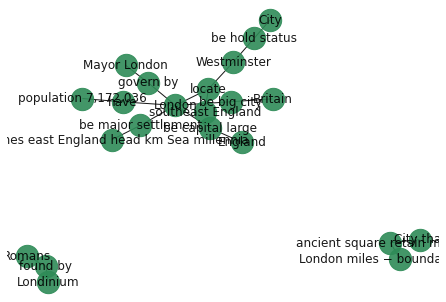

In [28]:

import spacy
from spacy.lang.en import English
import networkx as nx
import matplotlib.pyplot as plt
# If you created your component with `nlp.create_pipe('name')`: remove nlp.create_pipe and call `nlp.add_pipe('name')` instead.
def getSentences(text):
    nlp = English()
    nlp.add_pipe('sentencizer')
    document = nlp(text)
    return [sent.text for sent in document.sents]

def printToken(token):
    print(token.text, "->", token.dep_)

def appendChunk(original, chunk):
    return original + ' ' + chunk

def isRelationCandidate(token):
    deps = ["ROOT", "adj", "attr", "agent", "amod"]
    return any(subs in token.dep_ for subs in deps)

def isConstructionCandidate(token):
    deps = ["compound", "prep", "conj", "mod"]
    return any(subs in token.dep_ for subs in deps)

def processSubjectObjectPairs(tokens):
    subject = ''
    object = ''
    relation = ''
    subjectConstruction = ''
    objectConstruction = ''
    for token in tokens:
        printToken(token)
        if "punct" in token.dep_:
            continue
        if isRelationCandidate(token):
            relation = appendChunk(relation, token.lemma_)
        if isConstructionCandidate(token):
            if subjectConstruction:
                subjectConstruction = appendChunk(subjectConstruction, token.text)
            if objectConstruction:
                objectConstruction = appendChunk(objectConstruction, token.text)
        if "subj" in token.dep_:
            subject = appendChunk(subject, token.text)
            subject = appendChunk(subjectConstruction, subject)
            subjectConstruction = ''
        if "obj" in token.dep_:
            object = appendChunk(object, token.text)
            object = appendChunk(objectConstruction, object)
            objectConstruction = ''

    print (subject.strip(), ",", relation.strip(), ",", object.strip())
    return (subject.strip(), relation.strip(), object.strip())

def processSentence(sentence):
    tokens = nlp_model(sentence)
    return processSubjectObjectPairs(tokens)

def printGraph(triples):
    G = nx.Graph()
    for triple in triples:
        G.add_node(triple[0])
        G.add_node(triple[1])
        G.add_node(triple[2])
        G.add_edge(triple[0], triple[1])
        G.add_edge(triple[1], triple[2])

    pos = nx.spring_layout(G)
    plt.figure()
    nx.draw(G, pos, edge_color='black', width=1, linewidths=1,
            node_size=500, node_color='seagreen', alpha=0.9,
            labels={node: node for node in G.nodes()})
    plt.axis('off')
    plt.show()

if __name__ == "__main__":

    text = "London is the capital and largest city of England and the United Kingdom. Standing on the River " \
           "Thames in the south-east of England, at the head of its 50-mile (80 km) estuary leading to " \
           "the North Sea, London has been a major settlement for two millennia. " \
           "Londinium was founded by the Romans. The City of London, " \
           "London's ancient core − an area of just 1.12 square miles (2.9 km2) and colloquially known as " \
           "the Square Mile − retains boundaries that follow closely its medieval limits." \
           "The City of Westminster is also an Inner London borough holding city status. " \
           "Greater London is governed by the Mayor of London and the London Assembly." \
           "London is located in the southeast of England." \
           "Westminster is located in London." \
           "London is the biggest city in Britain. London has a population of 7,172,036."

    sentences = getSentences(text)
    nlp_model = spacy.load('en_core_web_sm')

    triples = []
    print (text)
    for sentence in sentences:
        triples.append(processSentence(sentence))

    printGraph(triples)

AttributeError: 'str' object has no attribute 'text'

In [13]:
subtree_matcher(nlp(candidate_sentences['sentence'][0]))

('engineer', 'energy')

In [8]:
path_to_csv = "/Users/awenc/NUIM/CS440/KG_NLPSystem/data/sentences.csv"
candidate_sentences = pd.read_csv(path_to_csv)
print(candidate_sentences.shape)
print(candidate_sentences['sentence'].sample(5))
print(candidate_sentences['sentence'][6])

(563, 1)
248    Syd was concerned because the United States ha...
123    The computer science department at Gordmont is...
155    The genie was very excited and wanted to begin...
238    The race began and the students rushed into th...
460    He also realizes that during the drought perio...
Name: sentence, dtype: object
At the same time, the lake was fed by water from various belts, so that also during drought periods it was sufficiency that the fed.


In [3]:
# nlp = spacy.load("en_core_sci_sm")

nlp =spacy.load("en_core_web_sm")

In [49]:
# nlpSci = spacy.load("en_core_sci_sm")
# nlpSci.add_pipe(nlp.create_pipe('sentencizer'))
# doc = nlpSci(text)

from data import *
text = biosci01
doc = nlp(text)
sent01=candidate_sentences['sentence'][0]
sent09=candidate_sentences['sentence'][8]

In [50]:
sent01
sent09

'This era has clearly left its mark on the faculty.'

In [ ]:
# Matcher class object
matcher = Matcher(nlp.vocab)

#define the pattern
pattern = [{'DEP':'amod', 'OP':"?"}, # adjectival modifier
           {'POS':'NOUN'},
           {'LOWER': 'such'},
           {'LOWER': 'as'},
           {'POS': 'PROPN'}]

matcher.add("matching_1", [pattern])
matches = matcher(doc)

span = doc[matches[0][1]:matches[0][2]]
print(span.text)

In [52]:
from app import clean
for s in candidate_sentences['sentence']:
    print(clean(s))

, Theme I:
Ronnie thought she had it made because she thought she had done well in the audition for a keyboard player.
Ronnie went to the music store, played some electric organs, and then purchased one.
Later she got a message from the guitar player about playing keyboards.
She wasn't in a band.
Ronnie was depressed that she had run up her credit card.
Set B, Theme 2:
Cindy was upset that she had blown her savings.
She wasn't employed.
Cindy was really happy about her tryout as dancer for a new musical.
That night she met the director about the dancer position.
Cindy got over to some stores, searched for, and bought some leotards.
She believed her troubles were over.
The computer science department at Gordmont is widely acknowledged to be one of the finest groups of its kind in the world.
Recently, the department has begun to attract research funding from both federal granting agencies and private research foundations.
Currently, the department is one of the best funded departments on

In [21]:
def get_relation(sentence):
    """
    Get relation within input sentenceence based on pattern provided.
    params: str - input of single sentenceence.
    """
    doc = nlp(sentence)

    # Matcher class object
    matcher = Matcher(nlp.vocab, validate=True)

    #define the pattern
    # TODO: explore matcher

    """
    Match 0 or more times / match 0 or 1 time(one relation in sencence?)
    Dodałem PROPN ale jeszcze nie przetestowałem.
    """
    # # define such as pattern
    # suchaspattern = [{'POS':'NOUN'}, 
    #        {'LOWER': 'such'}, 
    #        {'LOWER': 'as'}, 
    #        {'POS': 'PROPN'} #proper noun]
    # wrong pattern?
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'PROPN','OP':'?'},
            {'POS':'ADJ','OP':"?"}]
    #define the pattern
    suchas_pattern = [{'DEP':'amod', 'OP':"?"}, # adjectival modifier
           {'POS':'NOUN'},
           {'LOWER': 'such'},
           {'LOWER': 'as'},
           {'POS': 'PROPN'}]

    andor_pattern = [{'DEP':'amod', 'OP':"?"}, 
           {'POS':'NOUN'}, 
           {'LOWER': 'and', 'OP':"?"}, 
           {'LOWER': 'or', 'OP':"?"}, 
           {'LOWER': 'other'}, 
           {'POS': 'NOUN'}] 

    es_pattern = [{'DEP':'nummod','OP':"?"}, 
           {'DEP':'amod','OP':"?"}, 
           {'POS':'NOUN'}, 
           {'IS_PUNCT':True}, 
           {'LOWER': 'especially'}, 
           {'DEP':'nummod','OP':"?"}, 
           {'DEP':'amod','OP':"?"}, 
           {'POS':'NOUN'}] 
    # TODO Add verb matcher? IDK

    # matcher.add("matching_1", None, pattern) 

    # TODO: obczaic kod.
    # matches = matcher(doc) 
    
    # print(span.text)
    
    # for matcher.add had to change for 2 arguments and second as list
    # it happen after i had to downgrade python version to python=3.6
    # now it gets 2 arguments instead of 3, latter is type list so we can
    # add multiple patterns.
    matcher.add("matching_1", [pattern,suchas_pattern,andor_pattern,es_pattern])

    matches = matcher(doc)
    k = len(matches) - 1

    # span = doc[matches[0][1]:matches[0][2]] 
    span = doc[matches[k][1]:matches[k][2]]

    return(span.text)

get_relation(candidate_sentences['sentence'][4])

'placed around'

In [20]:
new_sent = candidate_sentences['sentence'][4]+" watermelon such as melon"
get_relation(new_sent)
# new_sent

'watermelon such'

In [53]:
# print(get_sents(text)[0])
# print(get_sents(text)[1])
# print(get_sents(text)[2])
# print('end of unclean\n')

# print(clean(get_sents(text)[0].strip()))
# print(clean(get_sents(text)[1].strip()))
# print(clean(get_sents(text)[2].strip()))


'Myeloid derived suppressor cells (MDSC) are immatur myeloid cells with immunosuppressive activity They accumulate in tumor bearing mice and human with different types of cancer, including hepatocellula carcinoma (HCC).'

In [13]:
def sent_(text):
    """
    This function sole pourpose is to represent look
    of example docstring.
    Parameters
    ----------
        text : str
            Block of text with multiple sentences

    Returns
    -------
    None
    Prints attributes of token object.
    text: Get the token text.
    POS: part-of-speech tag.
    DEP: dependency label.
    """
    sent = nlp(text)
    for token in sent:
        # Get the token text, part-of-speech tag and dependency label
        token_text = token.text
        token_pos = token.pos_
        token_dep = token.dep_
        print('{:<12}{:<10}{:<10}{:<10}'.format(token_text, token_pos, token_dep,spacy.explain(token_pos)))

sent_(fsent)

Myeloid     ADJ       amod      adjective 
derived     VERB      amod      verb      
suppressor  NOUN      compound  noun      
cells       NOUN      nsubj     noun      
(           PUNCT     punct     punctuation
MDSC        NOUN      appos     noun      
)           PUNCT     punct     punctuation
are         VERB      cop       verb      
immatur     ADJ       amod      adjective 
myeloid     ADJ       amod      adjective 
cells       NOUN      ROOT      noun      
with        ADP       case      adposition
immunosuppressiveADJ       amod      adjective 
activity    NOUN      nmod      noun      
They        PRON      nsubj     pronoun   
accumulate  VERB      acl:relcl verb      
in          ADP       case      adposition
tumor       NOUN      compound  noun      
bearing     VERB      amod      verb      
mice        NOUN      nmod      noun      
and         CCONJ     cc        coordinating conjunction
human       ADJ       conj      adjective 
with        ADP       case      a

In [32]:
def get_entities(sentence):
    # store entities in variable - object subject
    ent_1 = ''
    ent_2 = ''
    tok_dep = '' # dependency tag of previous token in the sentence
    tok_txt = '' # previous token in the senetence
    pfx = ''
    mod = ''

    for tok in nlp(sentence):
        if tok.dep_ != 'punct':
            if tok.dep_ == 'compound':
                pfx = tok.text
                if tok.dep_ == 'compound':
                    pfx = tok_txt +" "+tok.text

        if tok.dep_.endswith('mod') == True:
            mod = tok.text
            if tok.dep_ == 'compound':
                mod = tok_txt+" "+tok.text

        if tok.dep_.find("subj") == True:
            ent_1 = mod+" "+pfx+" "+tok.text
            tok_txt =''
            tok_dep=''
            pfx = ''
            mod =''

        if tok.dep_.find("obj") == True:
            ent_2 = mod+" "+pfx+" "+tok.text

        tok_dep = tok.dep_
        tok_txt = tok.text
    return [ent_1.strip(), ent_2.strip()]


get_entities(text)

In [41]:
# get_sent3(text)
# get_sents(text)
# graph(text)
# sent_(text)

'cells'

In [1]:
def get_triple(text):

    doc = nlp(text)
    sent = []

    for token in doc:
        # if the token is a verb
        if (token.pos_ in ['VERB','ROOT']):
            phrase =''
            # only extract noun or pronoun subjects
            for sub_tok in token.lefts:
                if (sub_tok.dep_ in ['nsubj','nsubjpass']) and (sub_tok.pos_ in ['NOUN','PROPN','PRON']):
                    # add subject to the phrase
                    phrase += sub_tok.text
                    # save the root of the verb in phrase
                    phrase += ' '+token.lemma_
                    # check for noun or pronoun direct objects
                    for sub_tok in token.rights:
                        # save the object in the phrase
                        if (sub_tok.dep_ in ['dobj']) and (sub_tok.pos_ in ['NOUN','PROPN']):
                            phrase += ' '+sub_tok.text
                            sent.append(phrase)

    return sent
get_triple(fsent) 

NameError: name 'get_triple' is not defined

In [44]:
get_entities(clean(text))

['activity  They', 'tumor  mice']

In [12]:
from spacy.matcher import DependencyMatcher

# "[subject] ... initially founded"
pattern = [
  # anchor token: founded
  {
    "RIGHT_ID": "founded",
    "RIGHT_ATTRS": {"ORTH": "founded"}
  },
  # founded -> subject
  {
    "LEFT_ID": "founded",
    "REL_OP": ">",
    "RIGHT_ID": "subject",
    "RIGHT_ATTRS": {"DEP": "nsubj"}
  },
  # "founded" follows "initially"
  {
    "LEFT_ID": "founded",
    "REL_OP": ";",
    "RIGHT_ID": "initially",
    "RIGHT_ATTRS": {"ORTH": "initially"}
  }
]

matcher = DependencyMatcher(nlp.vocab)
matcher.add("FOUNDED", [pattern])
matches = matcher(doc)

In [13]:
import spacy
from spacy.matcher import DependencyMatcher

# nlp = spacy.load("en_core_web_sm")
matcher = DependencyMatcher(nlp.vocab)
pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]
pattern = [
  {
    "RIGHT_ID": "anchor_founded",       # unique name
    "RIGHT_ATTRS": {"ORTH": "founded"}  # token pattern for "founded"
  },
    
]
matcher.add("FOUNDED", [pattern])
doc = nlp("Smith founded two companies.")
matches = matcher(doc)
print(matches) # [(4851363122962674176, [1])]

[(4851363122962674176, [1])]


In [14]:
import spacy
from spacy.matcher import DependencyMatcher

nlp = spacy.load("en_core_web_sm")
matcher = DependencyMatcher(nlp.vocab)

pattern = [
    {
        "RIGHT_ID": "anchor_founded",
        "RIGHT_ATTRS": {"ORTH": "founded"}
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_subject",
        "RIGHT_ATTRS": {"DEP": "nsubj"},
    },
    {
        "LEFT_ID": "anchor_founded",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object",
        "RIGHT_ATTRS": {"DEP": "dobj"},
    },
    {
        "LEFT_ID": "founded_object",
        "REL_OP": ">",
        "RIGHT_ID": "founded_object_modifier",
        "RIGHT_ATTRS": {"DEP": {"IN": ["amod", "compound"]}},
    }
]

matcher.add("FOUNDED", [pattern])
doc = nlp("Lee, an experienced CEO, has founded two AI startups.")
matches = matcher(doc)

print(matches) # [(4851363122962674176, [6, 0, 10, 9])]
# Each token_id corresponds to one pattern dict
match_id, token_ids = matches[0]
for i in range(len(token_ids)):
    print(pattern[i]["RIGHT_ID"] + ":", doc[token_ids[i]].text)

[(4851363122962674176, [7, 0, 10, 9])]
anchor_founded: founded
founded_subject: Lee
founded_object: startups
founded_object_modifier: AI


In [15]:
ruler = nlp.add_pipe("entity_ruler")
patterns = [{"label": "ORG", "pattern": "MyCorp Inc."}]
ruler.add_patterns(patterns)

doc = nlp("MyCorp Inc. is a company in the U.S.")
print([(ent.text, ent.label_) for ent in doc.ents])

[('MyCorp Inc.', 'ORG'), ('U.S.', 'GPE')]


In [16]:
print(list(doc.sents))

# Examine the entities extracted by the mention detector.
# Note that they don't have types like in SpaCy, and they
# are more general (e.g including verbs) - these are any
# spans which might be an entity in UMLS, a large
# biomedical database.
print(doc.ents)

[MyCorp Inc. is a company in the U.S.]
(MyCorp Inc., U.S.)


In [17]:
# We can also visualise dependency parses
# (This renders automatically inside a jupyter notebook!):
from spacy import displacy
displacy.render(next(doc.sents), style='dep', jupyter=True)

# See below for the generated SVG.
# Zoom your browser in a bit!

In [18]:
for i,_ in enumerate(doc):

    # doc[i].is_sent_start
    print(doc[i].is_sent_start)

True
False
False
False
False
False
False
False


In [19]:
def clean(text):
    # removing new line character
    text = re.sub('\n','', str(text))
    text = re.sub('\n ','',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("- ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing this �, guessing it was apostrophe
    text = re.sub("�s",'',str(text))
    text = re.sub('[a-z]+�','', str(text))
    text = re.sub('�[a-z]+','', str(text))
    text = re.sub('(','',str(text))
    text = re.sub(')','',str(text))
    # removing paragraph numbers
    text = re.sub('[0-9]+.\t','',str(text))
    # removing new line characters
    text = re.sub('\n ','',str(text))
    text = re.sub('\n',' ',str(text))
    # removing apostrophes
    text = re.sub("'s",'',str(text))
    # removing hyphens
    text = re.sub("-",' ',str(text))
    text = re.sub("- ",'',str(text))
    # removing quotation marks
    text = re.sub('\"','',str(text))
    # removing salutations
    text = re.sub("Mr\.",'Mr',str(text))
    text = re.sub("Mrs\.",'Mrs',str(text))
    # removing any reference to outside text
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    text = re.sub(' +',' ', str(text))

    return text
# type(clean(txt6))
txt6 = clean(txt6)

In [20]:
txt034="The fox jumped over the log."

In [21]:
txt6

'Not only are the faculty in this department extremely bright, they are able to enter the and present material in a clear engaging manner.'

In [22]:
sent_(txt6)

Not         PART      preconj   particle  
only        ADV       advmod    adverb    
are         VERB      advcl     verb      
the         DET       det       determiner
faculty     NOUN      nsubj     noun      
in          ADP       prep      adposition
this        DET       det       determiner
department  NOUN      pobj      noun      
extremely   ADV       advmod    adverb    
bright      ADJ       acomp     adjective 
,           PUNCT     punct     punctuation
they        PRON      nsubj     pronoun   
are         AUX       ROOT      auxiliary 
able        ADJ       acomp     adjective 
to          PART      aux       particle  
enter       VERB      xcomp     verb      
the         DET       det       determiner
and         CCONJ     cc        coordinating conjunction
present     ADJ       conj      adjective 
material    NOUN      dobj      noun      
in          ADP       prep      adposition
a           DET       det       determiner
clear       ADJ       amod      adjecti

In [34]:
# Get root of sentence
def n_chunk(sent):
    roots = ''
    doc = nlp(sent)
    for chunk in doc.noun_chunks:
        print(f"\nChunk Text: {chunk.text}\n-> Root: {chunk.root.text}\n-> Arc label:{chunk.root.dep_}\n-> Root head: {chunk.root.head.text}\n")
        roots += chunk.root.text+ ' ' +chunk.root.head.text+' '

    return roots

n_chunk(text)



Chunk Text: Myeloid derived suppressor cells
-> Root: cells
-> Arc label:nsubj
-> Root head: cells


Chunk Text: (MDSC
-> Root: MDSC
-> Arc label:appos
-> Root head: cells


Chunk Text: They
-> Root: They
-> Arc label:nsubj
-> Root head: accumulate


Chunk Text: humans
-> Root: humans
-> Arc label:conj
-> Root head: accumulate


Chunk Text: 
#
-> Root: #
-> Arc label:dobj
-> Root head: humans


Chunk Text: (HCC
-> Root: HCC
-> Arc label:appos
-> Root head: carcinoma



'cells cells MDSC cells They accumulate humans accumulate # humans HCC carcinoma '

NameError: name 'n_chunk' is not defined

In [25]:
def noun_chunks_sent(sentence):
    '''
    Take in single sntence and output
    nound chunks
    '''
    chunks = []
    sent = nlp(sentence)
    for chunk in sent.noun_chunks:
#         print(chunk.left())
        chunks.append(chunk)
#         print("Chunk: ",chunk)
    return chunks

In [26]:
chunks = noun_chunks_sent(txt2)
len(chunks)
chunks




[An engineer,
 the construction,
 an artificial lake,
 electric energy,
 the lake,
 he,
 a unique wide canal,
 water,
 a near valley,
 a mason,
 the stream,
 water,
 the canal,
 the surrounding areas,
 contrast,
 the drought periods,
 a unique stream,
 water,
 the lake,
 order,
 these mishaps,
 the mason,
 a unique wide canal,
 four small canals,
 whose total flow,
 the unique wide canal,
 These small canals,
 the lake,
 they,
 water,
 four different valleys,
 this way,
 only small amounts,
 water,
 each canal,
 flood periods,
 dangerous overflowing,
 the same time,
 the lake,
 water,
 various belts,
 drought periods,
 it,
 sufficiency]

In [27]:
txt2


'An engineer had to plan the construction of an artificial lake to produce electric energy. To feed the lake he thought to build a unique wide canal collecting water coming from a near valley. However, a mason pointed out that during the flood periods the stream of water flowing along the canal might be too strong and might damage the surrounding areas; by contrast, during the drought periods a unique stream of water might be insufficient to feed the lake. In order to avoid these mishaps, the mason suggested to build, instead of a unique wide canal, four small canals whose total flow was the same as the unique wide canal previously planned. These small canals were placed around the lake so that they conveyed water coming from four different valleys. In this way only small amounts of water could flow in each canal and thus during flood periods dangerous overflowing might not occur. At the same time, the lake was fed by water from various belts, so that also during drought periods it was

In [28]:
def nnch():
    doc = nlp(txt2)
    # nlp = spacy.load("en_core_web_sm")
    # doc = nlp("bright red apples on the tree")
    print(type(doc))
#     print(len(doc)+" Words added ")
    for i, token in enumerate(doc):
        
        if doc[i].n_lefts != 0:
            if doc[i].n_lefts > 1:
                print(doc[i].n_lefts)
                print([token.text for token in doc[i].lefts])
        
#         print([token.text for token in doc[i].lefts])
#         print(type(doc[i].lefts))
#         print([token.text for token in doc[i].lefts if token !=None])
#         print([token.text for token in doc[i].lefts])  
#         print([token.text for token in doc[i].rights])
#         print(doc[i].n_lefts)  # 2
#         print(doc[i].n_rights)  # 1
#         # TODO Lookup
#         doc[i].n_rights # give int value of how many something is to left or right?
nnch()



<class 'spacy.tokens.doc.Doc'>
2
['an', 'artificial']
3
['a', 'unique', 'wide']
2
['a', 'near']
3
['However', ',', 'mason']
2
['the', 'flood']
3
['that', 'during', 'might']
2
['the', 'surrounding']
2
['the', 'drought']
2
['a', 'unique']
6
[';', 'by', ',', 'during', 'stream', 'might']
3
['In', ',', 'mason']
3
['a', 'unique', 'wide']
2
['four', 'small']
2
['whose', 'total']
3
['the', 'unique', 'wide']
2
['These', 'small']
2
['canals', 'were']
3
['so', 'that', 'they']
2
['four', 'different']
2
['only', 'small']
3
['In', 'amounts', 'could']
4
['during', 'overflowing', 'might', 'not']
2
['the', 'same']
4
['At', ',', 'lake', 'was']
5
['so', 'that', 'also', 'during', 'it']
2
['that', 'the']


In [29]:
def noun_component(text):
    doc = nlp(text)
    print("Noun phrases:", [chunk.text for chunk in doc.noun_chunks])
    print("Verbs:", [token.lemma_ for token in doc if token.pos_ == "VERB"])
    
noun_component(txt2)

    
    

Noun phrases: ['An engineer', 'the construction', 'an artificial lake', 'electric energy', 'the lake', 'he', 'a unique wide canal', 'water', 'a near valley', 'a mason', 'the stream', 'water', 'the canal', 'the surrounding areas', 'contrast', 'the drought periods', 'a unique stream', 'water', 'the lake', 'order', 'these mishaps', 'the mason', 'a unique wide canal', 'four small canals', 'whose total flow', 'the unique wide canal', 'These small canals', 'the lake', 'they', 'water', 'four different valleys', 'this way', 'only small amounts', 'water', 'each canal', 'flood periods', 'dangerous overflowing', 'the same time', 'the lake', 'water', 'various belts', 'drought periods', 'it', 'sufficiency']
Verbs: ['have', 'plan', 'produce', 'feed', 'think', 'build', 'collect', 'come', 'point', 'period', 'flow', 'be', 'damage', 'surround', 'be', 'feed', 'avoid', 'suggest', 'build', 'be', 'plan', 'place', 'convey', 'come', 'flow', 'occur', 'feed', 'be']


In [30]:
def noun_component_list(text):
    doc = nlp(text)
    chunks = list(doc.noun_chunks)
    return chunks


In [31]:
noun_component_list(txt2)

[An engineer,
 the construction,
 an artificial lake,
 electric energy,
 the lake,
 he,
 a unique wide canal,
 water,
 a near valley,
 a mason,
 the stream,
 water,
 the canal,
 the surrounding areas,
 contrast,
 the drought periods,
 a unique stream,
 water,
 the lake,
 order,
 these mishaps,
 the mason,
 a unique wide canal,
 four small canals,
 whose total flow,
 the unique wide canal,
 These small canals,
 the lake,
 they,
 water,
 four different valleys,
 this way,
 only small amounts,
 water,
 each canal,
 flood periods,
 dangerous overflowing,
 the same time,
 the lake,
 water,
 various belts,
 drought periods,
 it,
 sufficiency]

['#  They', '#  carcinoma']

Myeloid     ADJ       amod      adjective 
derived     VERB      amod      verb      
suppressor  NOUN      compound  noun      
cells       NOUN      nsubj     noun      
(           PUNCT     punct     punctuation
MDSC        PROPN     appos     proper noun
)           PUNCT     punct     punctuation
are         AUX       ROOT      auxiliary 
immature    ADJ       acomp     adjective 

           SPACE     nmod      space     
#           PUNCT     case      punctuation
myeloid     ADJ       amod      adjective 
cells       NOUN      attr      noun      
with        ADP       prep      adposition
immunosuppressiveADJ       amod      adjective 
activity    NOUN      pobj      noun      
.           PUNCT     punct     punctuation

           SPACE     ROOT      space     
#           NOUN      nmod      noun      
They        PRON      nsubj     pronoun   
accumulate  VERB      relcl     verb      
in          ADP       prep      adposition
tumor       NOUN      npadvmod  noun      
-

In [3]:
## For this i have installed python 3.6 and it do not work but, maybe I can make it to work later.
# # Coreference resolution
# import spacy
# import neuralcoref

# nlp = spacy.load('en')
# neuralcoref.add_to_pipe(nlp)
# doc1 = nlp('My sister has a dog. She loves him.')
# print(doc1._.coref_clusters)

# doc2 = nlp('Angela lives in Boston. She is quite happy in that city.')
# for ent in doc2.ents:
#     print(ent._.coref_cluster)